
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 

    
Автор материала: Ольга Дайховская (@aiho в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 4 (демо).
## <center>  Прогнозирование популярности статей на TechMedia (Хабр) с помощью линейных моделей
    
**В задании Вам предлагается разобраться с тем, как работает TfidfVectorizer и DictVectorizer, затем обучить и настроить модель линейной регрессии Ridge на данных о публикациях на Хабрахабре. Пройдя все шаги, вы сможете получить бейзлайн для [соревнования](https://www.kaggle.com/c/howpop-habrahabr-favs-lognorm) (несмотря на old в названии, для этого задания соревнование актуально). 
Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/1gPt401drm84N2kdezwGWtPJN_JpaFqXoh6IwlWOslb4).**

**Описание соревнования**

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

**Приступим:** импортируем необходимые библиотеки и скачаем данные

In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt

Скачайте [данные](https://drive.google.com/file/d/1nV2qV9otN3LnVSDqy95hvpJdb6aWtATk/view?usp=sharing) соревнования (данные были удалены с Kaggle ради организации последующего идентичного соревнования, так что тут ссылка на Google Drive).

In [2]:
# при необходимости поменяйте путь к данным 
train_df = pd.read_csv('../../data/howpop_train.csv')
test_df  = pd.read_csv('../../data/howpop_test.csv')

In [3]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

In [5]:
test_df.head().T

,0,1,2,3,4
url,https://habrahabr.ru/post/314080/,https://habrahabr.ru/company/plesk/blog/313732/,https://habrahabr.ru/company/etagi/blog/314000/,https://habrahabr.ru/company/knopka/blog/314030/,https://geektimes.ru/company/audiomania/blog/2...
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru,habrahabr.ru,geektimes.ru
post_id,314080,313732,314000,314030,282058
published,2016-11-01 01:05:00,2016-11-01 05:42:00,2016-11-01 08:33:00,2016-11-01 09:00:00,2016-11-01 09:44:00
author,@fsou11,NaN,NaN,NaN,NaN
flow,develop,marketing,admin,develop,NaN
polling,True,False,False,False,False
content_len,20132,12389,72839,29572,9642
title,Опыт использования MassTransit 3.0,Геймификация форума на движке XenForo,Кластер высокой доступности на postgresql 9.6 ...,Как перестать бояться и полюбить синтаксически...,Мифы и реальность: Что нужно знать о современн...


Убедимся, что данные отсортированы по признаку `published`

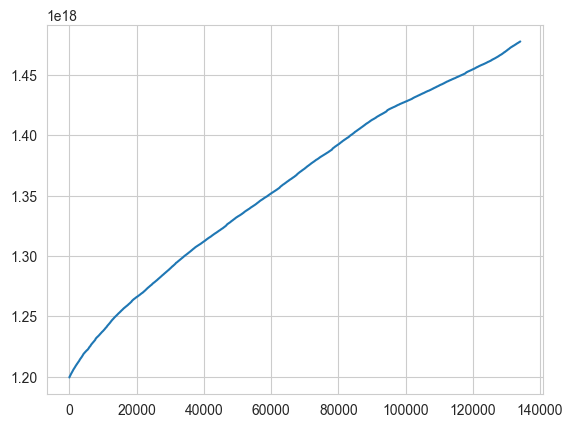

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

**Чтобы ответить на вопросы 1 и 2, можно использовать [pandas.DataFrame.corr()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html), [pandas.to_datetime()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) и [pandas.Series.value_counts()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)**

<font color='red'>Вопрос 1.</font> Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)
- да
- нет
- не знаю

In [7]:
corr_matrix = train_df.corr(numeric_only=True)
corr_matrix

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


<Axes: >

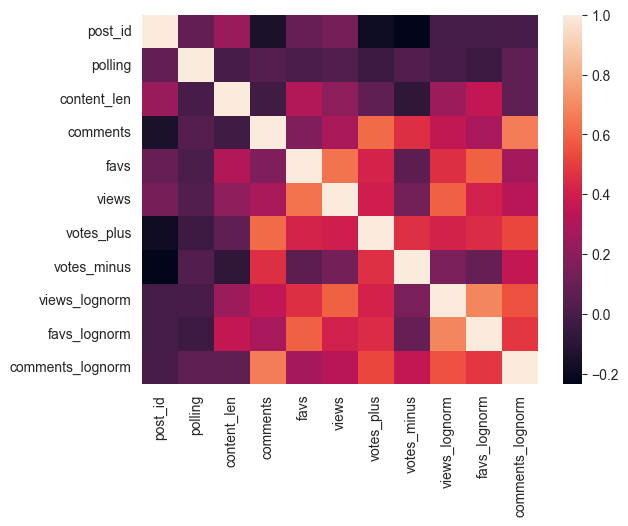

In [8]:
import seaborn as sns
sns.heatmap(corr_matrix)

<font color='red'>Вопрос 2.</font> В каком году было больше всего публикаций? (Рассматриваем train_df)
- 2014
- 2015
- 2016
- 2017

In [9]:
date_time_published = train_df["published"].apply(lambda x: pd.to_datetime(x))
date_time_published

0        2008-01-01 18:19:00
1        2008-01-01 18:30:00
2        2008-01-01 18:34:00
3        2008-01-02 01:32:00
4        2008-01-02 14:34:00
                 ...        
134132   2016-10-31 21:45:00
134133   2016-10-31 22:44:00
134134   2016-10-31 23:26:00
134135   2016-10-31 23:52:00
134136   2016-10-31 23:56:00
Name: published, Length: 134137, dtype: datetime64[ns]

In [10]:
date_time_published.apply(lambda x: x.year).value_counts()

published
2015    23452
2016    16316
2014    16180
2012    15972
2013    15537
2011    15063
2010    13091
2009    10783
2008     7743
Name: count, dtype: int64

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [11]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [12]:
len(train_df), train_size

(134137, 93895)

In [13]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной

X_test = test_df.loc[:, features]

In [14]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:, :]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer

**TF-IDF** (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален количеству употребления этого слова в документе, и обратно пропорционален частоте употребления слова в других документах коллекции. [Подробнее в источнике](https://ru.wikipedia.org/wiki/TF-IDF)

TfidfVectorizer преобразует тексты в матрицу TF-IDF признаков.

**Основные параметры TfidfVectorizer в sklearn:**
- **min_df** - при построении словаря слова, которые встречаются *реже*, чем указанное значение, игнорируются
- **max_df** - при построении словаря слова, которые встречаются *чаще*, чем указанное значение, игнорируются
- **analyzer** - определяет, строятся ли признаки по словам или по символам (буквам)
- **ngram_range** - определяет, формируются ли признаки только из отдельных слов или из нескольких слов (в случае с analyzer='char' задает количество символов). Например, если указать analyzer='word' и ngram_range=(1,3),то признаки будут формироваться из отдельных слов, из пар слов и из троек слов.
- **stop_words** - слова, которые игнорируются при построении матрицы

Более подробно с параметрами можно ознакомиться в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

**Инициализируйте TfidfVectorizer с параметрами min_df=3, max_df=0.3 и ngram_range=(1, 3).<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 3.</font> Какой размер у полученного словаря?
- 43789
- 50624
- 93895
- 74378

In [15]:
vectorizer_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

X_train_title = vectorizer_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_title.transform(X_valid['title'])
X_test_title = vectorizer_title.transform(X_test['title'])

In [16]:
# Можно посмотреть словарь в виде {'термин': индекс признака,...}
vectorizer_title.vocabulary_

{'новогодний': 31497,
 'подарок': 36257,
 'блоггерам': 14241,
 'wordpress': 12172,
 'новогодний подарок': 31499,
 'сумасшедшие': 45476,
 'яйца': 50489,
 'или': 22661,
 'сервис': 42745,
 'для': 18811,
 'отслеживания': 34225,
 'посетителей': 37373,
 'или сервис': 22833,
 'сервис для': 42751,
 'для отслеживания': 19413,
 'или сервис для': 22834,
 'сервис для отслеживания': 42753,
 'сглаживание': 42460,
 'шрифтов': 49862,
 'отрисовка': 34214,
 'сглаживание шрифтов': 42461,
 'почему': 37632,
 'мне': 28231,
 'не': 30755,
 'нравится': 31925,
 'iphone': 5951,
 'почему мне': 37659,
 'мне не': 28233,
 'не нравится': 30851,
 'всеобщая': 16456,
 'доступность': 20285,
 'действии': 18272,
 'чем': 49165,
 'суть': 45504,
 'проекта': 39310,
 'ru': 9541,
 'search': 9842,
 'запускается': 21584,
 'понедельник': 37201,
 'mobile': 7315,
 'выбор': 16759,
 'способа': 44575,
 'связи': 42437,
 'обзор': 32095,
 'под': 36147,
 'windows': 11973,
 'под windows': 36185,
 'онлайн': 33063,
 'банкинг': 13661,
 'оформле

In [17]:
len(vectorizer_title.vocabulary_)

50624

<font color='red'>Вопрос 4.</font> Какой индекс у слова 'python'?
- 1
- 10
- 9065
- 15679

In [18]:
vectorizer_title.vocabulary_["python"]

9065

**Инициализируйте TfidfVectorizer, указав analyzer='char'.<br />
Примените метод fit_transform к X_train['title'] и метод transform к X_valid['title'] и X_test['title']**

<font color='red'>Вопрос 5.</font> Какой размер у полученного словаря?
- 218
- 510
- 125
- 981

In [19]:
vectorizer_title_ch = TfidfVectorizer(analyzer="char")

X_train_title_ch = vectorizer_title_ch.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_title_ch.transform(X_valid['title'])
X_test_title_ch = vectorizer_title_ch.transform(X_test['title'])

In [20]:
# Здесь так же можно посмотреть словарь
# Заметьте насколько отличаются словари для TfidfVectorizer с analyzer='word' и analyzer='char'
vectorizer_title_ch.vocabulary_

{'н': 133,
 'о': 134,
 'в': 122,
 'г': 123,
 'д': 124,
 'и': 128,
 'й': 129,
 ' ': 0,
 'п': 135,
 'а': 120,
 'р': 136,
 'к': 130,
 'б': 121,
 'л': 131,
 'е': 125,
 'м': 132,
 '—': 170,
 'w': 61,
 'o': 53,
 'r': 56,
 'd': 42,
 'p': 54,
 'e': 43,
 's': 57,
 '2': 18,
 '.': 14,
 '3': 19,
 'с': 137,
 'у': 139,
 'ш': 144,
 'я': 151,
 'ц': 142,
 ',': 12,
 'т': 138,
 'ж': 126,
 'ф': 140,
 'ь': 148,
 'ч': 143,
 'i': 47,
 'h': 46,
 'n': 52,
 'm': 51,
 'b': 40,
 'l': 50,
 '0': 16,
 'щ': 145,
 'k': 49,
 'v': 60,
 'a': 39,
 'u': 59,
 ':': 26,
 'c': 41,
 'з': 127,
 'ы': 147,
 '«': 76,
 '»': 85,
 'х': 141,
 'j': 48,
 '?': 31,
 't': 58,
 '-': 13,
 '1': 17,
 '8': 24,
 '!': 1,
 '9': 25,
 '5': 21,
 '7': 23,
 'q': 55,
 'y': 63,
 'x': 62,
 'g': 45,
 'ю': 150,
 'ъ': 146,
 '4': 20,
 '=': 29,
 '(': 8,
 ')': 9,
 '+': 11,
 'f': 44,
 '…': 178,
 'э': 149,
 '6': 22,
 'z': 64,
 '/': 15,
 '$': 4,
 'ё': 152,
 "'": 7,
 '№': 187,
 '–': 169,
 '[': 33,
 ']': 35,
 '_': 37,
 '\xa0': 71,
 '*': 10,
 '%': 5,
 '{': 65,
 '}': 6

In [21]:
len(vectorizer_title_ch.vocabulary_)

218

## Работа с категориальными признаками

Для обработки категориальных признаков 'author', 'flow', 'domain' мы будем использовать DictVectorizer из sklearn.

In [22]:
feats = ['author', 'flow', 'domain']
X_train[feats][:5]

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,NaN,geektimes.ru


Рассмотрим как он работает на примере первых пяти строк

In [23]:
# сначала заполняем пропуски прочерком
X_train[feats][:5].fillna('-')

,author,flow,domain
0,@Tapac,develop,habrahabr.ru
1,@DezmASter,design,habrahabr.ru
2,@DezmASter,design,habrahabr.ru
3,@Taoorus,design,habrahabr.ru
4,@dennydo,-,geektimes.ru


In [24]:
# Преобразуем датафрейм в словарь, где ключами являются индексы объектов (именно для этого мы транспонировали датафрейм),
# а значениями являются словари в виде 'название_колонки':'значение'
X_train[feats][:5].fillna('-').T.to_dict()

{0: {'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'},
 1: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 2: {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'},
 3: {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'},
 4: {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}}

In [25]:
# В DictVectorizer нам нужно будет передать список словарей для каждого объекта в виде 'название_колонки':'значение',
# поэтому используем .values()
X_train[feats][:5].fillna('-').T.to_dict().values()

dict_values([{'author': '@Tapac', 'flow': 'develop', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@DezmASter', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@Taoorus', 'flow': 'design', 'domain': 'habrahabr.ru'}, {'author': '@dennydo', 'flow': '-', 'domain': 'geektimes.ru'}])

In [26]:
# В итоге получается разреженная матрица
dict_vect = DictVectorizer()
dict_vect_matrix = dict_vect.fit_transform(X_train[feats][:5].fillna('-').T.to_dict().values())
dict_vect_matrix

<5x9 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>

In [27]:
# Но можно преобразовать ее в numpy array с помощью .toarray()
dict_vect_matrix.toarray()

array([[0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0., 0.]])

In [28]:
# В получившейся матрице 5 строк (по числу объектов) и 9 столбцов
# Далее разберемся почему колонок именно 9
dict_vect_matrix.shape

(5, 9)

Посмотрим сколько уникальных значений в каждой колонке.<br />
Суммарно их 9 - столько же, сколько и колонок. Это объясняется тем, что для категориальных признаков со строковыми значениями DictVectorizer делает кодирование бинарными признаками - каждому уникальному значению признака соответствует один новый бинарный признак, который равен 1 только в том случае, если в исходной матрице этот признак принимает значение, которому соответствует эта колонка новой матрицы.

In [29]:
for col in feats:
    print(col, len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


Также можно посмотреть что означает каждая колонка полученной матрицы

In [30]:
# например, самая первая колонка называется 'author=@DezmASter' - то есть принимает значение 1 только если автор @DezmASter
dict_vect.feature_names_

['author=@DezmASter',
 'author=@Taoorus',
 'author=@Tapac',
 'author=@dennydo',
 'domain=geektimes.ru',
 'domain=habrahabr.ru',
 'flow=-',
 'flow=design',
 'flow=develop']

**Инициализируйте DictVectorizer с параметрами по умолчанию.<br />
Примените метод fit_transform к X_train[feats] и метод transform к X_valid[feats] и X_test[feats]**

In [31]:
vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats].fillna('-').T.to_dict().values())
X_valid_feats = vectorizer_feats.transform(X_valid[feats].fillna('-').T.to_dict().values())
X_test_feats = vectorizer_feats.transform(X_test[feats].fillna('-').T.to_dict().values())

In [32]:
X_valid_feats.shape

(40242, 17869)

In [33]:
X_valid_title.shape

(40242, 50624)

Соединим все полученные матрицы при помощи scipy.sparse.hstack()

In [34]:
X_train_new = scipy.sparse.hstack([X_train_title, X_train_feats, X_train_title_ch])
X_valid_new = scipy.sparse.hstack([X_valid_title, X_valid_feats, X_valid_title_ch])
X_test_new =  scipy.sparse.hstack([X_test_title, X_test_feats, X_test_title_ch])

## Обучение модели

Далее будем использовать Ridge, линейную модель с l2-регуляризацией.
[Документация](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

Основной параметр Ridge - **alpha, коэффициент регуляризации**. Регуляризация используется для улучшения обобщающей способности модели - прибавляя к функционалу потерь сумму квадратов весов, умноженную на коэффициент регуляризации (та самая alpha), мы штрафуем модель за слишком большие значения весов и не позволяем ей переобучаться. Чем больше этот коээфициент, тем сильнее эффект.

**Обучите две модели на X_train_new, y_train, задав в первой alpha=0.1 и random_state = 1, а во второй alpha=1.0 и random_state = 1**

**Рассчитайте среднеквадратичную ошибку каждой модели (mean_squared_error). Сравните значения ошибки на обучающей и тестовой выборках и ответьте на вопросы.**

<font color='red'>Вопрос 6.</font> Выберите верные утверждения:
- обе модели показывают одинаковый результат (среднеквадратичная ошибка отличается не больше чем на тысячные), регуляризация ничего не меняет
- при alpha=0.1 модель переобучается
- среднеквадратичная ошибка первой модели на тесте меньше
- при alpha=1.0 у модели обобщающая способность лучше, чем у при alpha=0.1

In [35]:
%%time
model1 = Ridge(alpha=0.1, random_state=1)
model1.fit(X_train_new, y_train)
model1

CPU times: total: 4.36 s
Wall time: 4.62 s


Ridge(alpha=0.1, random_state=1)

In [36]:
train_preds1 = model1.predict(X_train_new)
valid_preds1 = model1.predict(X_valid_new)

print('Ошибка на трейне', mean_squared_error(y_train, train_preds1))
print('Ошибка на тесте', mean_squared_error(y_valid, valid_preds1))

Ошибка на трейне 0.18351184292425282
Ошибка на тесте 0.9058876616972553


In [37]:
%%time
model2 = Ridge(alpha=1, random_state=1)
model2.fit(X_train_new, y_train)

CPU times: total: 1.86 s
Wall time: 1.93 s


Ridge(alpha=1, random_state=1)

In [38]:
train_preds2 = model2.predict(X_train_new)
valid_preds2 = model2.predict(X_valid_new)

print('Ошибка на трейне', mean_squared_error(y_train, train_preds2))
print('Ошибка на тесте', mean_squared_error(y_valid, valid_preds2))

Ошибка на трейне 0.28625114587268546
Ошибка на тесте 0.701236402931393


## Baseline

**Теперь попытаемся получить бейзлайн для соревования - используйте Ridge с параметрами по умолчанию и обучите модель на всех данных - соедините X_train_new X_valid_new (используйте scipy.sparse.vstack()), а целевой переменной будет y.**

In [39]:
%%time
X_train_final =  scipy.sparse.vstack([X_train_new, X_valid_new])
model = Ridge()

model.fit(X_train_final, y)

test_preds = model.predict(X_test_new)

CPU times: total: 2.97 s
Wall time: 3.35 s


In [40]:
sample_submission = pd.read_csv('../../data/habr_sample_submission.csv', 
                                index_col='url')

In [41]:
sample_submission.head()

,favs_lognorm
url,
https://habrahabr.ru/post/314080/,0.323588
https://habrahabr.ru/company/plesk/blog/313732/,0.560105
https://habrahabr.ru/company/etagi/blog/314000/,0.667039
https://habrahabr.ru/company/knopka/blog/314030/,0.149563
https://geektimes.ru/company/audiomania/blog/282058/,0.670754


In [42]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = test_preds
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv('ridge_baseline.csv')

In [43]:
from sklearn.model_selection import GridSearchCV

params = {"alpha": np.linspace(0.1, 10, 20)}
grid_search = GridSearchCV(Ridge(), param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train_final, y)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])})

In [44]:
grid_search.best_params_

{'alpha': 3.2263157894736847}

In [52]:
model_tuned = Ridge(alpha=3.2263157894736847)
model_tuned.fit(X_train_new, y_train)

Ridge(alpha=3.2263157894736847)

In [53]:
train_preds3 = model_tuned.predict(X_train_new)
valid_preds3 = model_tuned.predict(X_valid_new)

print('Ошибка на трейне', mean_squared_error(y_train, train_preds3))
print('Ошибка на тесте', mean_squared_error(y_valid, valid_preds3))

Ошибка на трейне 0.3877739900031685
Ошибка на тесте 0.6826107716676837


In [55]:
y_valid

93895    -0.362514
93896    -1.327373
93897     1.237445
93898     0.679587
93899     0.012569
            ...   
134132    2.124862
134133   -0.511814
134134   -0.656390
134135   -0.655385
134136   -0.290955
Name: favs_lognorm, Length: 40242, dtype: float64

In [56]:
valid_preds3

array([ 0.04350275,  0.48428646,  0.44544218, ..., -0.10245151,
        0.05676297,  0.39523219])

In [47]:
tuned_pred = model_tuned.predict(X_test_new)
tuned_pred

array([ 0.42803009, -1.01881968,  0.51510544, ...,  0.70784315,
        0.03226208,  0.51827141])

In [48]:
ridge_submission = sample_submission.copy()
ridge_submission['favs_lognorm'] = tuned_pred
# это будет бейзлайн "Простое решение"
ridge_submission.to_csv('ridge_tuned.csv')